In [1]:
#!pip install --user pyarrow

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid

#tqdm.pandas()

In [6]:
conservation = pd.read_csv("../../data/vep/conservation/Chr5.tsv.gz", sep="\t")
conservation

,pos,PhastCons,PhyloP
0,73,0.137841,0.486723
1,74,0.120058,0.630370
2,75,0.082986,-0.672660
3,76,0.083501,0.630370
4,77,0.070315,0.410230
...,...,...,...
24279498,26975493,0.149043,0.383414
24279499,26975494,0.139126,0.383414
24279500,26975495,0.121064,-0.819180
24279501,26975496,0.144156,0.383414


In [3]:
#cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
#cis_eQTL

In [4]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [7]:
#model_name = "window-128_tokenization-no_model-bert"
#model_name = "window-1000_tokenization-bpe8192_model-bert"
#model_name = "window-128_tokenization-no_model-convnet"
#model_name = "DNABERT"
model_name = "window-512_tokenization-no_model-convnet"


high_AF_strategy = "filter"


df = pd.read_parquet(f"vep_full_{model_name}.parquet")
pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]

if high_AF_strategy == "filter":
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
elif high_AF_strategy == "redefine":
    df["alt_AF"] = df.AC / df.AN
    df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
    df["ref_AF"] = 1 - df.alt_AF
    df["alt_AC"] = df.AC
    df["ref_AC"] = df.AN - df.AC
    df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
    df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
else:
    raise Exception(f"high_AF_strategy {high_AF_strategy} not supported ")
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.420048,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.983859,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-1.196805,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.309975,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.772574,0.000941
...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-1.600120,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.037436,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,1.037334,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-1.161967,0.001957


In [8]:
df = df.merge(conservation, how="inner", on="pos")
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.420048,0.180943,4.065988e-05,-2.247958
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.983859,0.000958,5.789353e-03,-0.031569
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-1.196805,0.001896,2.593449e-05,-2.233914
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.309975,0.002828,8.936376e-02,1.008387
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.772574,0.000941,4.240783e-03,0.006849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319365,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-1.600120,0.002893,3.660736e-01,1.170096
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.037436,0.000976,1.420844e-05,-1.248585
1319367,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,1.037334,0.002938,8.210040e-07,-4.405118
1319368,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-1.161967,0.001957,2.430046e-02,1.170096


In [69]:
# remember to uncomment this
#df.model_llr = -df.PhastCons
#df.model_llr = -(df.PhyloP.abs())

In [9]:
df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))

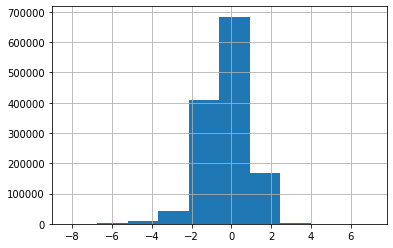

In [10]:
df.model_llr.hist()

In [72]:
spearmanr(df.AC, df.model_llr)

SpearmanrResult(correlation=0.04365554857594392, pvalue=0.0)

In [73]:
df["Status"] = "Neither"
df.loc[df.AC <= 10, "Status"] = "Rare"
df.loc[df.AC > 100, "Status"] = "Common"
df.Status.value_counts()

Rare       827888
Neither    317962
Common     173520
Name: Status, dtype: int64

In [74]:
def compute_odds_ratio(df, threshold_quantile):
    df.loc[df.model_llr <= df.model_llr.quantile(threshold_quantile), "ModelScoreTier"] = "Low"
    df.loc[df.model_llr > df.model_llr.quantile(threshold_quantile), "ModelScoreTier"] = "High"
    group_counts = df[df.Status!="Neither"].groupby(["Status", "ModelScoreTier"]).size()
    print(group_counts)
    group_counts = group_counts.values.reshape((2, 2))
    print(group_counts)
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    return odds_ratio, p_value

In [86]:
threshold_quantiles = np.logspace(-3, -1, 3) #[1e-3, 1e-2, 1e-1]
odds_ratios, p_values = zip(*[compute_odds_ratio(df, threshold_quantile) for threshold_quantile in threshold_quantiles])
results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values))
model_name2 = "ConvNet"
#model_name2 = "PhastCons"
#model_name2 = "PhyloP"
#model_name2 = "DNABERT"
results["Model"] = model_name2
results.to_csv(f"odds_ratio_{model_name2}.tsv", sep="\t", index=False)
results

Status  ModelScoreTier
Common  High              173450
        Low                   70
Rare    High              826902
        Low                  986
dtype: int64
[[173450     70]
 [826902    986]]
Status  ModelScoreTier
Common  High              172718
        Low                  802
Rare    High              818400
        Low                 9488
dtype: int64
[[172718    802]
 [818400   9488]]
Status  ModelScoreTier
Common  High              160211
        Low                13309
Rare    High              740395
        Low                87493
dtype: int64
[[160211  13309]
 [740395  87493]]


,threshold_quantile,odds_ratio,p_value,Model
0,0.001,2.954603,8.908681e-25,ConvNet
1,0.010,2.496734,3.005582e-175,ConvNet
2,0.100,1.422515,3.919255e-310,ConvNet


In [16]:
def get_model_path(model_name):
    if not "chromatin" in model_name:
        return f"odds_ratio_{model_name}.tsv"
    else:
        m = model_name.split(" ")[0]
        return f"../chromatin/odds_ratio_{m}.tsv"


model_names = ["ConvNet", "PhastCons", "DNABERT", "DeepSEA (chromatin)", "ConvNet (chromatin)"]
# ["ConvNet", r"$-$PhastCons", "DNABERT", r"$-$|Phylop|"],
dataframes = []
for m in model_names:
    dataframe = pd.read_csv(get_model_path(m), sep="\t")
    dataframe["Model"] = m
    dataframes.append(dataframe)
results = pd.concat(dataframes, ignore_index=True)
results["Significant"] = results.p_value < 0.05
results

,threshold_quantile,odds_ratio,p_value,Model,Significant
0,0.001,2.954603,8.908681e-25,ConvNet,True
1,0.010,2.496734,3.005582e-175,ConvNet,True
2,0.100,1.422515,3.919255e-310,ConvNet,True
3,0.001,2.371485,1.597350e-18,PhastCons,True
4,0.010,1.992135,1.795710e-116,PhastCons,True
5,0.100,1.325508,1.073623e-210,PhastCons,True
6,0.001,1.767395,2.008715e-09,DNABERT,True
7,0.010,1.433640,3.109905e-36,DNABERT,True
8,0.100,1.105161,2.561419e-29,DNABERT,True
9,0.001,1.691986,7.570233e-09,DeepSEA (chromatin),True


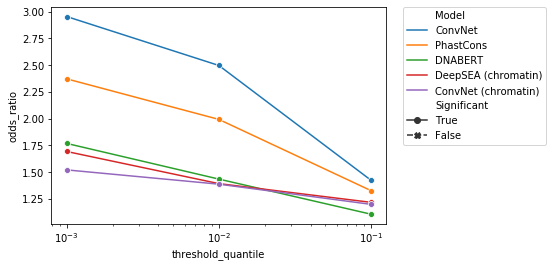

In [18]:
g = sns.lineplot(
    data=results,
    x="threshold_quantile",
    y="odds_ratio",
    hue="Model",
    style="Significant",
    markers=True,
    style_order=[True, False],
)
g.set(xscale='log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig("odds_ratios.pdf", bbox_inches='tight')

In [74]:
mannwhitneyu(df.loc[df.Status=="Rare", "model_llr"], df.loc[df.Status=="Common", "model_llr"], alternative="less")

MannwhitneyuResult(statistic=66498194154.0, pvalue=0.0)

In [20]:
(df.consequence=="stop_gained").sum()

3395

In [27]:
df.consequence[df.consequence.str.contains("splice")].value_counts().head()

intron_variant,splice_region_variant                        18833
missense_variant,splice_region_variant                       2649
splice_region_variant,synonymous_variant                     2189
5_prime_UTR_variant,intron_variant,splice_region_variant      736
intron_variant,missense_variant,splice_region_variant         556
Name: consequence, dtype: int64

In [28]:
df2 = df.groupby("consequence").agg({"model_llr": "mean", "pos": "size"}).rename(columns={"model_llr": "mean_model_llr", "pos": "counts"})
df2 = df2[df2.counts >= 2000].sort_values("mean_model_llr")
df2

,mean_model_llr,counts
consequence,,
stop_gained,-2.359356,3395
"missense_variant,splice_region_variant",-0.456393,2649
"intron_variant,splice_region_variant",-0.383199,18833
5_prime_UTR_variant,-0.380782,47287
"5_prime_UTR_variant,upstream_gene_variant",-0.363110,10315
"5_prime_UTR_variant,downstream_gene_variant",-0.355150,3242
"missense_variant,non_coding_transcript_exon_variant",-0.324211,2034
"splice_region_variant,synonymous_variant",-0.322173,2189
"5_prime_UTR_variant,missense_variant",-0.314200,3513


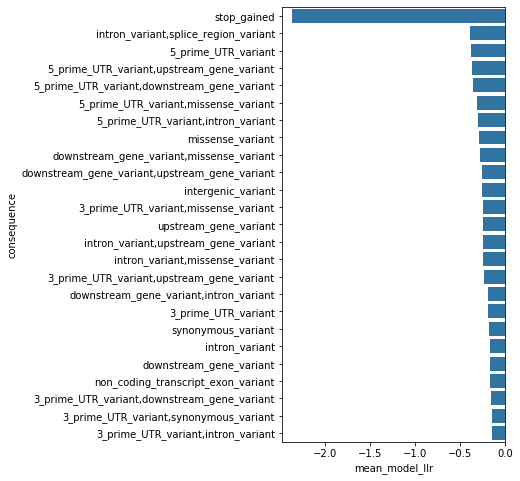

In [22]:
plt.figure(figsize=(4,8))
ax = sns.barplot(data=df2.reset_index(), y="consequence", x="mean_model_llr", color="C0")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.savefig("llr_by_consequence.pdf", bbox_inches='tight')

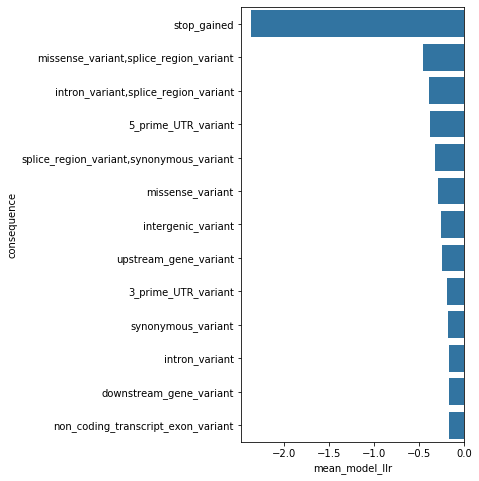

In [30]:
plt.figure(figsize=(4,8))
df3 = df2.reset_index()
df3 = df3[(df3.consequence.str.contains("splice")) | ~(df3.consequence.str.contains(","))]
ax = sns.barplot(data=df3, y="consequence", x="mean_model_llr", color="C0")
#ax.set_xticklabels(ax.get_xticklabels(),rotation=90);
plt.savefig("llr_by_consequence2.pdf", bbox_inches='tight')

In [83]:
# https://aragwas.1001genomes.org/#/gene/AT5G03560
df[(df.pos.isin([902307, 902185]))]

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,ModelScoreTier
51329,Chr5,902185,A,G,230,2240,AT5G03560.2,563,"intron_variant,missense_variant",0.059404,0.102679,0.342112,0.059487,Common,High
51335,Chr5,902307,T,C,234,2236,AT5G03560.2,441,intron_variant,1.410567,0.104651,0.001506,0.203466,Common,High


In [84]:
# https://aragwas.1001genomes.org/#/gene/AT5G15380
df[(df.pos.isin([4991952, 4993063, 4994504]))]

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,ModelScoreTier
241088,Chr5,4991952,G,C,76,2224,AT5G15380.1,605,missense_variant,-0.966936,0.034173,0.975153,2.779168,Neither,Neither
241139,Chr5,4993063,A,T,76,2174,AT5G15380.1,1716,intron_variant,0.417465,0.034959,0.006460,-0.343869,Neither,High
241203,Chr5,4994504,A,C,78,2232,AT5G15390.1,-641,missense_variant,0.290868,0.034946,0.124116,0.232349,Neither,High


In [85]:
df[(df.pos.isin([903797, 903915, 904774]))]

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,ModelScoreTier
51463,Chr5,904774,T,C,164,2230,AT5G03570.1,1018,missense_variant,-2.199468,0.073543,0.99862,1.52069,Common,Neither
